# CNN

### Image classification with Convolutional Neural Networks

**Dogs vs Cats**

A model to categorize images of dogs and cats.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Import the required libraries

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/dogscats/"
sz = 224

- **PATH** is the path to your data
- **sz** is the size that the images will be resized to in order to ensure that the training runs quickly

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

In [6]:
os.listdir(PATH)

['valid', 'test1', 'tmp', 'sample', 'train', 'models']

In [7]:
files = os.listdir(f'{PATH}/valid/cats')[:5]
files

['cat.4597.jpg',
 'cat.1711.jpg',
 'cat.11458.jpg',
 'cat.600.jpg',
 'cat.9411.jpg']

- This folder structure is the most common approach for how image classification dataset is shared and provided.

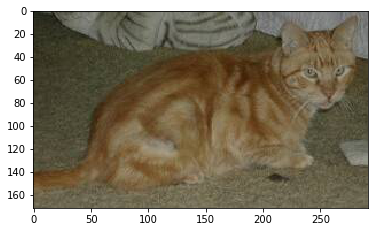

In [8]:
img = plt.imread(f'{PATH}valid/cats/{files[3]}')
plt.imshow(img);

### Here is how raw data looks like

In [9]:
img.shape

(172, 292, 3)

In [10]:
img[:4, :4]

array([[[66, 72, 62],
        [71, 77, 67],
        [75, 81, 71],
        [76, 82, 72]],

       [[31, 37, 27],
        [35, 41, 31],
        [40, 46, 36],
        [42, 48, 38]],

       [[31, 37, 25],
        [34, 40, 28],
        [38, 44, 32],
        [38, 44, 32]],

       [[38, 41, 30],
        [40, 43, 32],
        [40, 43, 32],
        [38, 41, 30]]], dtype=uint8)

**Info of raw data**
- img is a 3 dimensional array (a.k.a. rank 3 tensor)
- The three items (e.g. [66, 72, 62]) represents Red Green Blue pixel values between 0 and 255
- The three items (e.g. [158, 110, 62]) represents Red Green Blue pixel values between 0 and 255

## Let’s train a model

We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision

In [11]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                     
    0      0.04517    0.028233   0.9895    
    1      0.041758   0.027858   0.9905                       



[array([0.02786]), 0.9905]

**Above architevture Info**
- This will do 2 epochs which means it is going to look at the entire set of images twice.
- The last of three numbers in the output is the accuracy on the validation set.
- The first two are the value of loss function (in this case the cross-entropy loss) for the training set and the validation set.
- The start (e.g. 0., 1.) is the epoch number.

### Analyzing results: looking at pictures


As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

This is what the validation dataset label (think of it as the correct answers) looks like:

In [12]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

What do these 0’s and 1’s represents?

In [13]:
data.classes

['cats', 'dogs']

- `data` contains the validation and training data
- `learn` contains the model

Let’s make predictions for the validation set (predictions are in log scale):

In [14]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [15]:
log_preds[:10]

array([[ -0.00004, -10.06188],
       [ -0.00041,  -7.81025],
       [ -0.00004, -10.10899],
       [ -0.00422,  -5.46908],
       [ -0.00004, -10.10455],
       [ -0.00012,  -9.03196],
       [ -0.00001, -11.12618],
       [ -0.00828,  -4.79821],
       [ -0.00016,  -8.76793],
       [ -0.00017,  -8.67606]], dtype=float32)

- The output represents a prediction for cats, and prediction for dogs


In [16]:
preds = np.argmax(log_preds, axis=1) # from log probabilities to 0 or 1
probs = np.exp(log_preds[:, 1])      # PR(dog)

#### Helper function for visualizing the results

In [17]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) == is_correct)

In [24]:
def plots(ims, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims) // rows, i+1)
        sp.axis('Off')
        if titles is not None:
              sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [27]:
def load_img_id(ds, idx):
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds, x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16, 8)) if len(imgs) > 0 else print('Not Found')

In [30]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if(y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly Classified


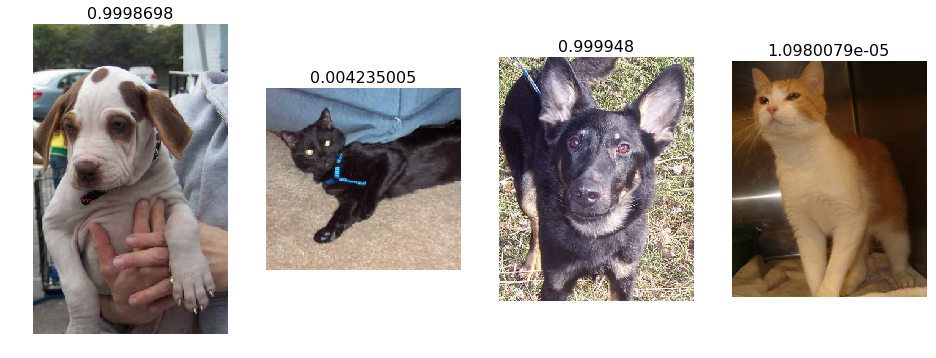

In [28]:
# 1. A few correct labels at random 
plot_val_with_title(rand_by_correct(True), "Correctly Classified")

Incorrectly Classified


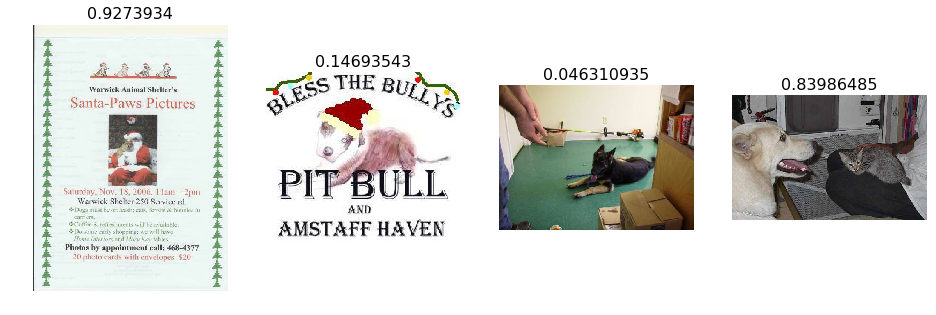

In [29]:
# 1. A few correct labels at random 
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

Most correct cats


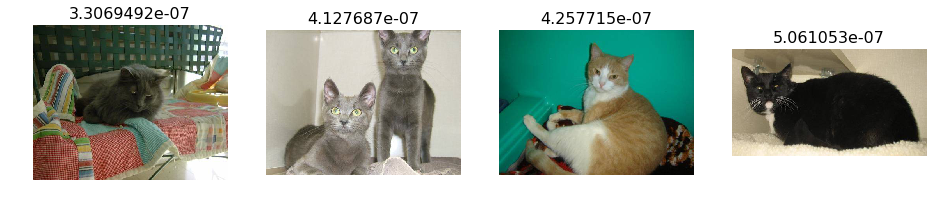

In [31]:
# 3. The most correct labels of each class (i.e. those with highest probability that are correct)
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


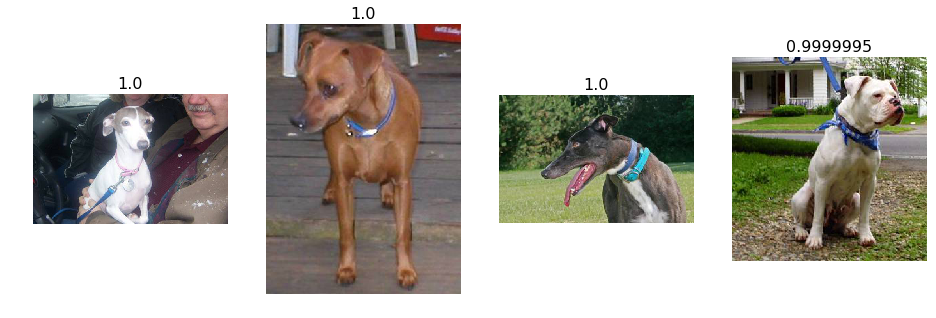

In [33]:
# 4. The most correct labels of each class (i.e. those with highest probability that are correct)
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


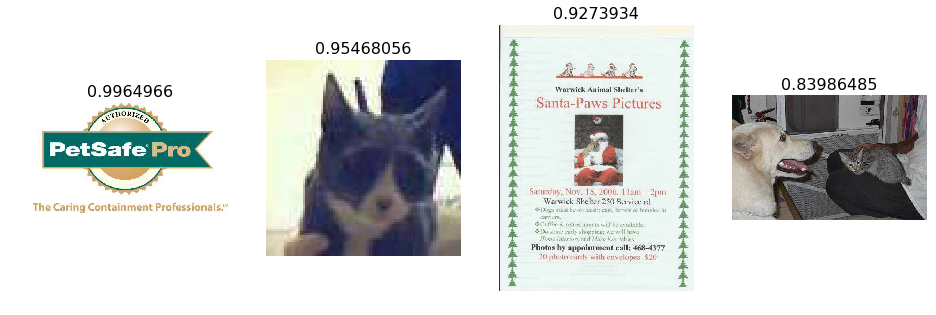

In [34]:
# 5. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


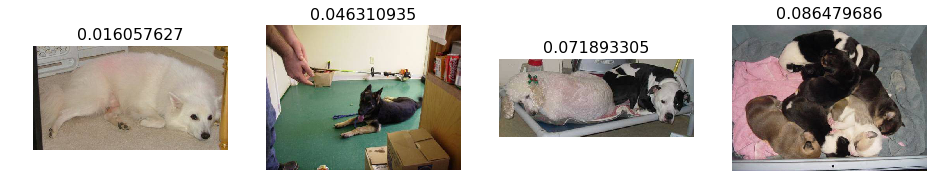

In [35]:
# 6. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most Uncetain Predictions


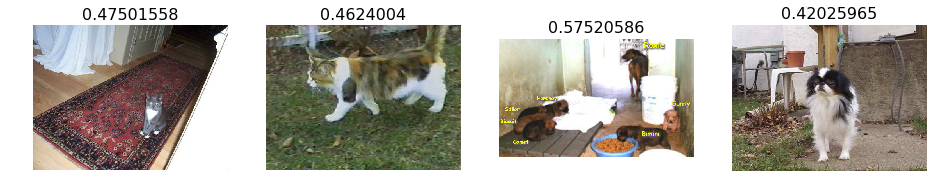

In [36]:
most_uncertain = np.argsort(np.abs(probs - 0.5))[:4]
plot_val_with_title(most_uncertain, 'Most Uncetain Predictions')

- Why is it important to look at these images?Is to find a way to visualize what it has built. Because if we wants to make the model better, then we needs to take advantage of the things that is doing well and fix the things that is doing badly.

- In this case, we have learned something about the dataset itself which is that there are some images that are in here that probably should not be. But it is also clear that this model has room to improve (e.g. data augmentation — which we will learn later)

### Choosing a learning rate

The learning rate determines how quickly or how slowly you want to update the weights (or parameters). Learning rate is one of the most difficult parameters to set, because it significantly affects model performance.

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.


The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()

 85%|████████▍ | 305/360 [00:05<00:01, 54.54it/s, loss=0.359] 


Our learn object contains an attribute sched that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

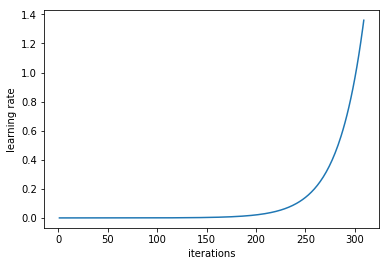

In [38]:
learn.sched.plot_lr()

Note that in the previous plot iteration is one iteration (or minibatch) of SGD. In one epoch there are (num_train_samples/batch_size) iterations of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

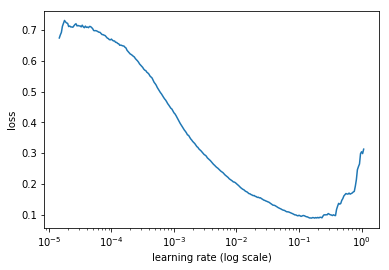

In [39]:
learn.sched.plot()

- We then pick the learning rate where the loss is still clearly improving — in this case 1e-2 (0.01)

#### Choosing number of epochs 

-  As many as you would like, but accuracy might start getting worse if you run it for too long. It is something called “overfitting”
- Another consideration is the available time.